# Python environment tweaks

If you are working in `binder` then install matplotlib

In [1]:
try:

    import matplotlib

except ModuleNotFoundError:

    %pip install matplotlib

Check [matplotlib](https://matplotlib.org/) library is available

In [2]:
import matplotlib

matplotlib.__version__

'3.4.3'

Check `tubular` is available

In [3]:
import tubular

tubular.__version__

'0.3.1'

# Download dataset from the UCI Machine Learning Repository
We will be using the [Bank Marketing](https://archive.ics.uci.edu/ml/datasets/bank+marketing) data which represents a phone marketing campaign to sell term deposits. 

In [4]:
import pandas as pd
import numpy as np
import urllib
import zipfile

In [5]:
pd.set_option("display.max_columns", 50)

## Define data locations

In [6]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
zip_filename = "bank-additional.zip"
data_filename = "bank-additional/bank-additional-full.csv"

## Download and unzip data

In [7]:
r = urllib.request.urlretrieve(data_url, zip_filename)

In [8]:
with zipfile.ZipFile(zip_filename, "r") as zip_ref:

    zip_ref.extractall(".")

## Load data

In [9]:
df_original = pd.read_csv(data_filename, sep=";")
df_original.shape

(41188, 21)

Map the response to be numeric

In [10]:
df_original["y"] = df_original["y"].map({"no": 0, "yes": 1})

Add a sample column

In [11]:
np.random.seed(1)
df_original["sample"] = np.random.random_sample(df_original.shape[0])

Remove columns not to be included in modelling

In [12]:
y_original = df_original["y"]
df_original = df_original.drop(columns=["duration", "y"])

In [13]:
df_original.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,sample
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.417022
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.720324
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.000114
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.302333
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.146756


In [14]:
y_original.head()

0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int64

# Explore data

In [15]:
df = df_original.copy()
y = y_original.copy()

### Response

In [16]:
y.mean()

0.11265417111780131

<AxesSubplot:>

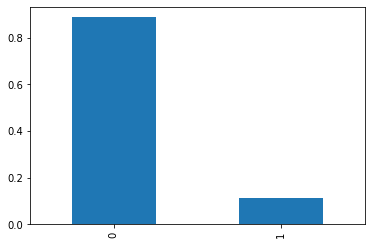

In [17]:
y.value_counts(normalize=True).plot(kind="bar")

### Explanatory variables

In [18]:
import plotting as p

In [19]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
sample            float64
dtype: object

#### Numeric

Add response back in just for the purposes of plotting

In [20]:
df["y"] = y

In [21]:
numeric_cols = list(df.select_dtypes("number").columns.values)

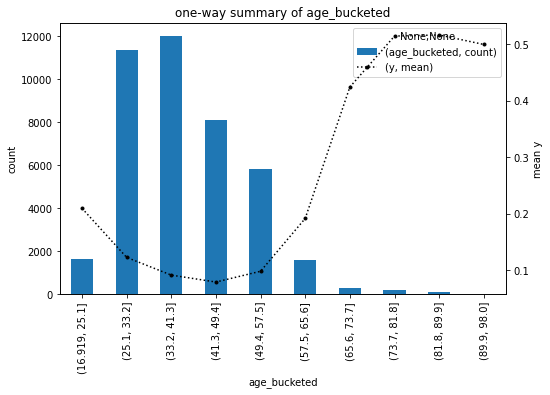

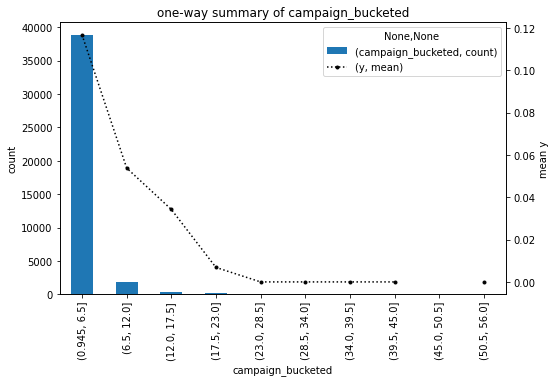

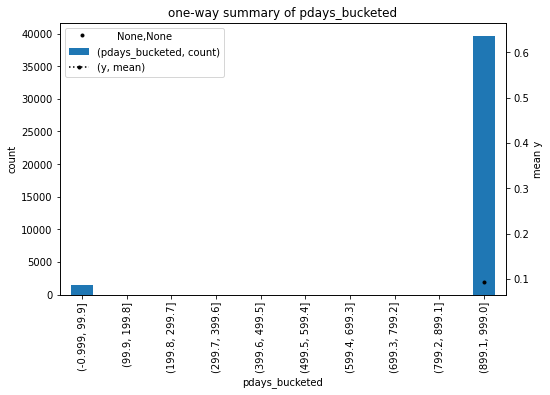

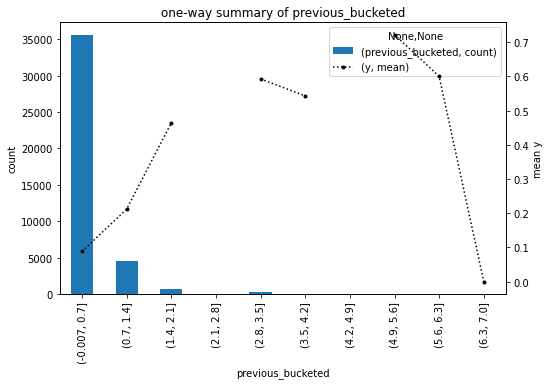

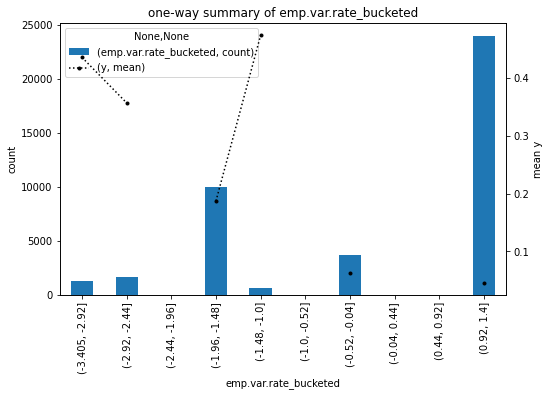

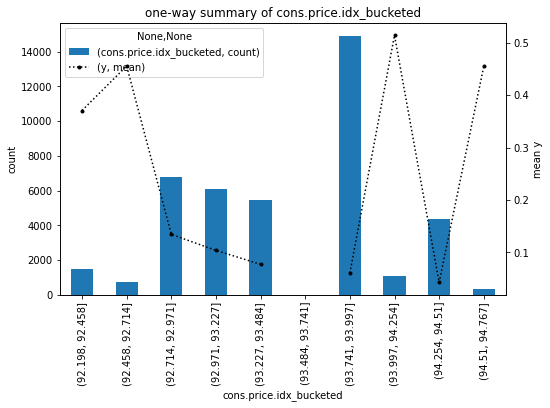

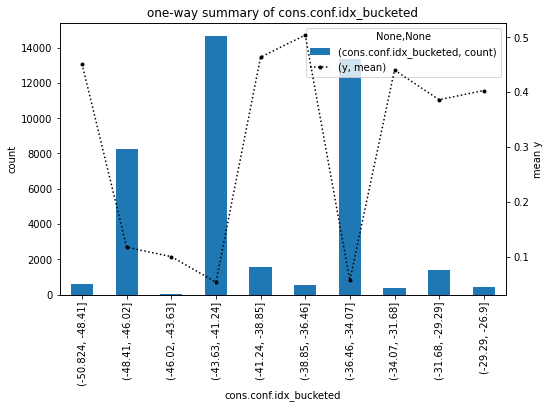

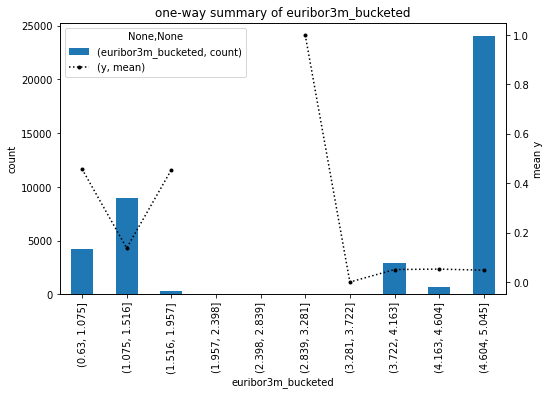

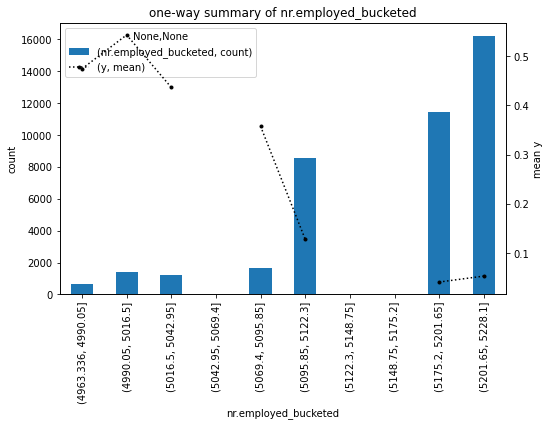

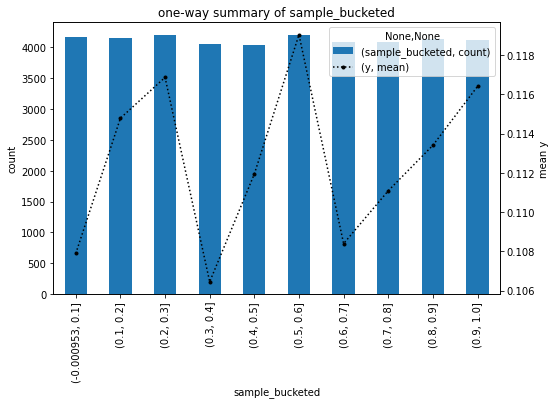

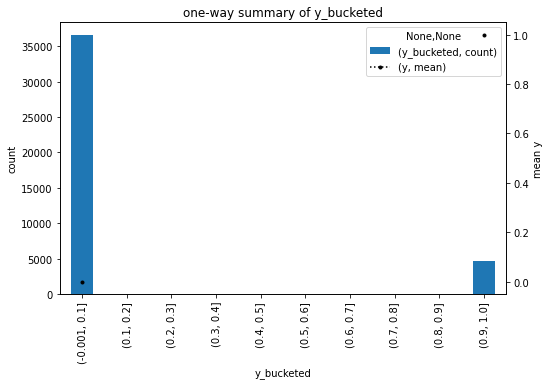

In [22]:
for col in numeric_cols:

    # bin the numeric for the purposes of visualisation
    bucketed_col = f"{col}_bucketed"
    df[bucketed_col] = pd.cut(df[col], bins=10)

    p.one_way_summary_plot(df, bucketed_col)

#### Categorical

In [23]:
categorical_cols = list(df.select_dtypes("object").columns.values)

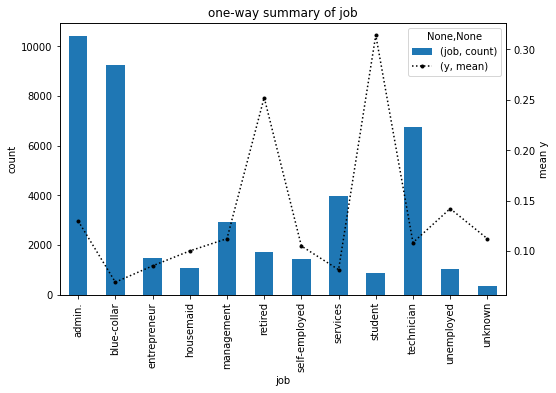

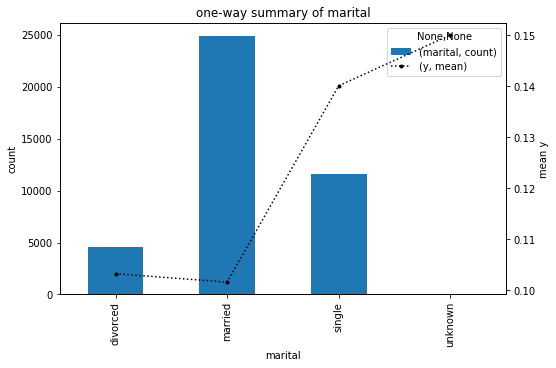

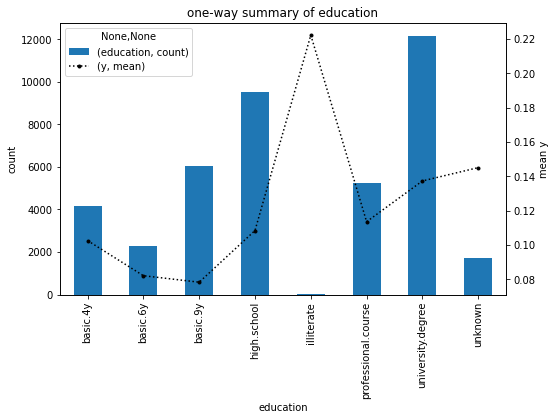

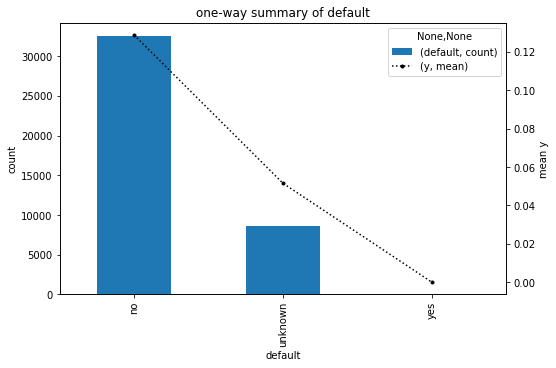

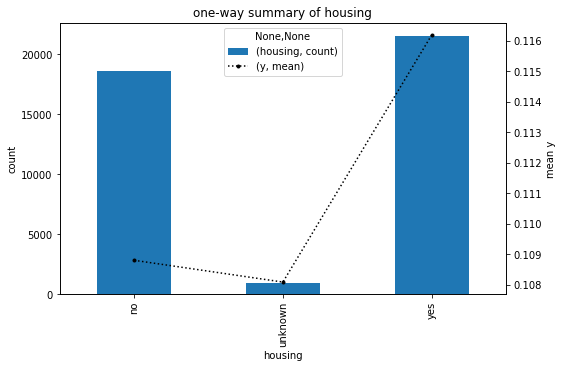

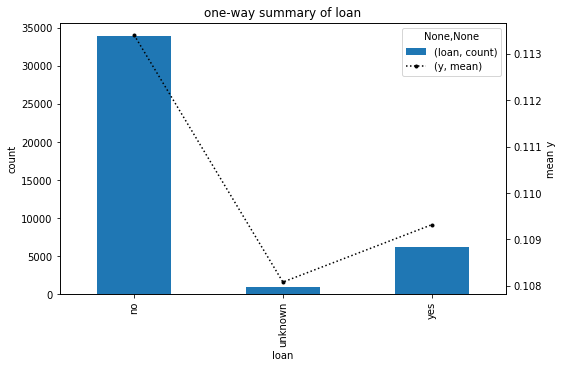

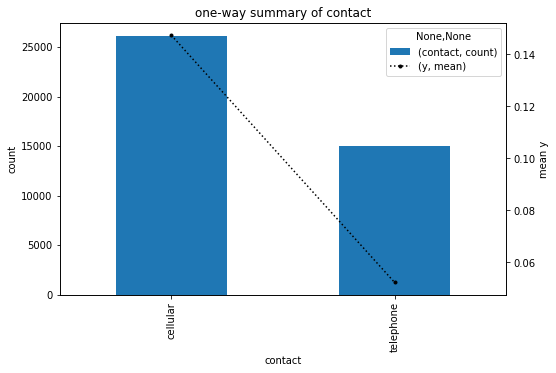

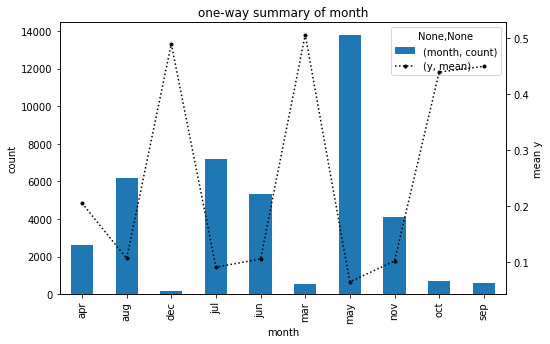

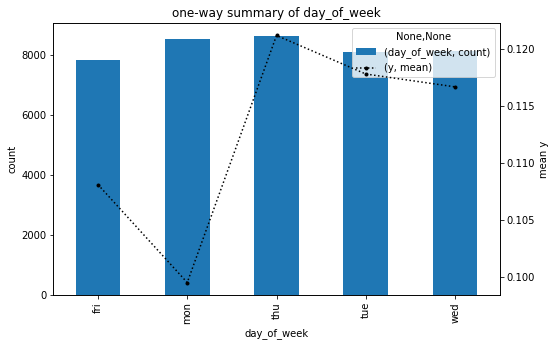

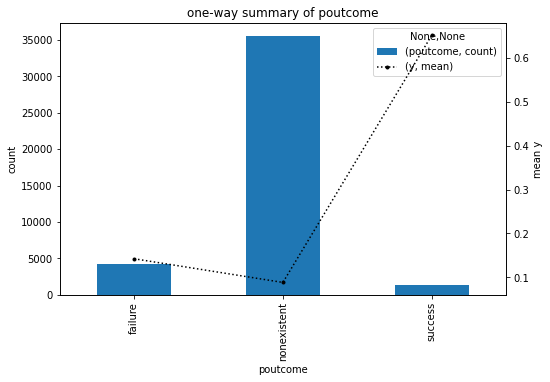

In [24]:
for col in categorical_cols:
    p.one_way_summary_plot(df, col)

Separate the response again after plotting

In [25]:
df = df.drop(columns="y")

## Nulls

In [26]:
df.isnull().sum()

age                        0
job                        0
marital                    0
education                  0
default                    0
housing                    0
loan                       0
contact                    0
month                      0
day_of_week                0
campaign                   0
pdays                      0
previous                   0
poutcome                   0
emp.var.rate               0
cons.price.idx             0
cons.conf.idx              0
euribor3m                  0
nr.employed                0
sample                     0
age_bucketed               0
campaign_bucketed          0
pdays_bucketed             0
previous_bucketed          0
emp.var.rate_bucketed      0
cons.price.idx_bucketed    0
cons.conf.idx_bucketed     0
euribor3m_bucketed         0
nr.employed_bucketed       0
sample_bucketed            0
y_bucketed                 0
dtype: int64

In [27]:
(df == "unknown").sum()

age                           0
job                         330
marital                      80
education                  1731
default                    8597
housing                     990
loan                        990
contact                       0
month                         0
day_of_week                   0
campaign                      0
pdays                         0
previous                      0
poutcome                      0
emp.var.rate                  0
cons.price.idx                0
cons.conf.idx                 0
euribor3m                     0
nr.employed                   0
sample                        0
age_bucketed                  0
campaign_bucketed             0
pdays_bucketed                0
previous_bucketed             0
emp.var.rate_bucketed         0
cons.price.idx_bucketed       0
cons.conf.idx_bucketed        0
euribor3m_bucketed            0
nr.employed_bucketed          0
sample_bucketed               0
y_bucketed                    0
dtype: i

# Transformers
[Tubular](https://github.com/lvgig/tubular) implements various transformers that can be used to apply pre-processing steps prior to modelling.

In [28]:
from tubular.base import DataFrameMethodTransformer
from tubular.capping import CappingTransformer
from tubular.imputers import NearestMeanResponseImputer
from tubular.mapping import MappingTransformer
from tubular.nominal import (
    GroupRareLevelsTransformer,
    OneHotEncodingTransformer,
    MeanResponseTransformer,
)
from tubular.numeric import CutTransformer
from tubular.strings import SeriesStrMethodTransformer

In [29]:
df = df_original.copy()

## Capping
The [capping module](https://tubular.readthedocs.io/en/latest/api.html#capping-module) provides options for capping at min and max values.

In [30]:
capping_transformer = CappingTransformer(quantiles={"age": [0.1, 0.9]}, verbose=False)

In [31]:
capping_transformer.fit(df)

CappingTransformer(capping_values={'age': [28.0, 55.0]},
                   quantiles={'age': [0.1, 0.9]})

In [32]:
df2 = capping_transformer.transform(df)

In [33]:
df["age"].min(), df2["age"].min()

(17, 28)

In [34]:
df["age"].max(), df2["age"].max()

(98, 55)

## Discretisation
The `CutTransformer` in the [numeric module](https://tubular.readthedocs.io/en/latest/api/tubular.numeric.CutTransformer.html) can be used to discretise or bucket a numeric column.

In [35]:
bucketing_transformer = CutTransformer(
    column="previous",
    new_column_name="previous_bucketed",
    cut_kwargs={"bins": [0, 1, 2, 3, 10], "include_lowest": True, "right": False},
    verbose=False,
)

In [36]:
df3 = bucketing_transformer.transform(df2)

In [37]:
df3["previous_bucketed"].value_counts()

[0, 1)     35563
[1, 2)      4561
[2, 3)       754
[3, 10)      310
Name: previous_bucketed, dtype: int64

## String extraction
The [strings module](https://tubular.readthedocs.io/en/latest/api.html#strings-module) currently only has one transformer, `SeriesStrMethodTransformer` that allows [pandas.Series.str](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.html) methods to be applied.

In [38]:
string_extraction_transformer = SeriesStrMethodTransformer(
    columns="education",
    new_column_name="basic_education",
    pd_method_name="find",
    pd_method_kwargs={"sub": "basic"},
)

In [39]:
df4 = string_extraction_transformer.transform(df3)

In [40]:
df4["basic_education"].value_counts(dropna=False)

-1    28675
 0    12513
Name: basic_education, dtype: int64

## Mapping
The `MappingTransformer` from the [mapping module](https://tubular.readthedocs.io/en/latest/api/tubular.mapping.MappingTransformer.html) provides a way to from one set of values to another.

In [41]:
mapping_transformer = MappingTransformer(
    mappings={
        "job": {
            "admin.": "new_group",
            "blue-collar": "new_group",
            "housemaid": "new_group",
        },
        "education": {
            "basic.4y": 1,
            "basic.6y": 2,
            "basic.9y": 3,
            "high.school": 4,
            "university.degree": 5,
            "professional.course": 6,
            "university.degree": 7,
            "unknown": np.NaN,
            "illiterate": 7,
        },
        "default": {"no": 0, "unknown": 0, "yes": 1},
        "housing": {"no": 0, "unknown": 0, "yes": 1},
        "loan": {"no": 0, "unknown": 0, "yes": 1},
        "month": {
            "jan": "winter",
            "feb": "winter",
            "mar": "sping",
            "apr": "sping",
            "may": "sping",
            "jun": "summer",
            "jul": "summer",
            "aug": "summer",
            "sep": "autumn",
            "oct": "autumn",
            "nov": "autumn",
            "dec": "winter",
        },
    }
)

In [42]:
df4 = mapping_transformer.transform(df3)

In [43]:
df4["job"].value_counts(dropna=False)

new_group        20736
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [44]:
df4["education"].value_counts(dropna=False)

7.0    12186
4.0     9515
3.0     6045
6.0     5243
1.0     4176
2.0     2292
NaN     1731
Name: education, dtype: int64

In [45]:
df4["default"].value_counts(dropna=False)

0    41185
1        3
Name: default, dtype: int64

In [46]:
df4["loan"].value_counts(dropna=False)

0    34940
1     6248
Name: loan, dtype: int64

In [47]:
df4["housing"].value_counts(dropna=False)

1    21576
0    19612
Name: housing, dtype: int64

In [48]:
df4["month"].value_counts(dropna=False)

summer    18670
sping     16947
autumn     5389
winter      182
Name: month, dtype: int64

## Sum

In [49]:
sum_transformer = DataFrameMethodTransformer(
    new_column_name="sum_debt",
    pd_method_name="sum",
    columns=["loan", "housing", "default"],
    pd_method_kwargs={"axis": 1},
    drop_original=False,
)

In [50]:
df5 = sum_transformer.transform(df4)

In [51]:
df5["sum_debt"].value_counts(dropna=False)

1    20443
0    17053
2     3692
Name: sum_debt, dtype: int64

## Imputation
The [imputation module](https://tubular.readthedocs.io/en/latest/api.html#imputers-module) has various ways to deal with missing (`null`) values.

In [52]:
imputation_transformer = NearestMeanResponseImputer(columns="education")

In [53]:
imputation_transformer.fit(X=df5, y=y)

NearestMeanResponseImputer(columns=['education'])

In [54]:
df6 = imputation_transformer.transform(df5)

In [55]:
df6["education"].isnull().sum()

0

## Nominal columns
The [nominal module](https://tubular.readthedocs.io/en/latest/api.html#nominal-module) contains different ways to treat categorical variables.

### Rare level grouping

In [56]:
grouping_transformer = GroupRareLevelsTransformer(
    columns="job", cut_off_percent=0.05, verbose=False
)

In [57]:
grouping_transformer.fit(df6)

GroupRareLevelsTransformer(columns=['job'], cut_off_percent=0.05)

In [58]:
df7 = grouping_transformer.transform(df6)

In [59]:
df7["job"].value_counts(dropna=False)

new_group     20736
rare           6816
technician     6743
services       3969
management     2924
Name: job, dtype: int64

### One hot encoding

In [60]:
one_hot_encoder = OneHotEncodingTransformer(
    columns=[
        "marital",
        "contact",
        "month",
        "day_of_week",
        "poutcome",
        "previous_bucketed",
    ],
    drop_original=True,
    verbose=False,
)

In [61]:
one_hot_encoder.fit(df7)

OneHotEncodingTransformer(columns=['marital', 'contact', 'month', 'day_of_week',
                                   'poutcome', 'previous_bucketed'],
                          drop_original=True)

In [62]:
df8 = one_hot_encoder.transform(df7)

/Users/richardangell/opt/miniconda3/envs/tubular-workshop/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Mean response encoding

In [63]:
mean_response_transformer = MeanResponseTransformer(columns="job", verbose=False)

In [64]:
mean_response_transformer.fit(X=df8, y=y)

MeanResponseTransformer(columns=['job'])

In [65]:
df9 = mean_response_transformer.transform(df8)

In [66]:
df9["job"].value_counts(dropna=False).sort_index()

0.081381     3969
0.101080    20736
0.108260     6743
0.112175     2924
0.170628     6816
Name: job, dtype: int64

# Pipelines
[Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) chain together several transformers.

In [67]:
from sklearn.pipeline import Pipeline

## Simple pipeline

In [68]:
pipeline_1 = Pipeline(
    steps=[
        ("capping", CappingTransformer(quantiles={"age": [0.1, 0.9]}, verbose=False)),
        (
            "discretisation",
            CutTransformer(
                column="previous",
                new_column_name="previous_bucketed",
                cut_kwargs={
                    "bins": [0, 1, 2, 3, 10],
                    "include_lowest": True,
                    "right": False,
                },
                verbose=False,
            ),
        ),
    ]
)

## Shorthand pipeline construction
[make_pipeline](https://scikit-learn.org/stable/modules/compose.html#construction) can be used as short-hand to create `Pipeline` objects without specifying names for steps

In [69]:
from sklearn.pipeline import make_pipeline

In [70]:
make_pipeline(
    CappingTransformer(quantiles={"age": [0.1, 0.9]}, verbose=False),
    CutTransformer(
        column="previous",
        new_column_name="previous_bucketed",
        cut_kwargs={"bins": [0, 1, 2, 3, 10], "include_lowest": True, "right": False},
        verbose=False,
    ),
)

Pipeline(steps=[('cappingtransformer',
                 CappingTransformer(capping_values={},
                                    quantiles={'age': [0.1, 0.9]})),
                ('cuttransformer',
                 CutTransformer(column='previous',
                                cut_kwargs={'bins': [0, 1, 2, 3, 10],
                                            'include_lowest': True,
                                            'right': False},
                                new_column_name='previous_bucketed'))])

## `fit`, `transform`, `fit_transform`

In [71]:
df = df_original.copy()

In [72]:
test_sample_cut_off = 0.8

In [73]:
X_train = df.loc[df["sample"] < test_sample_cut_off]
X_test = df.loc[df["sample"] >= test_sample_cut_off]
y_train = y.loc[df["sample"] < test_sample_cut_off]
y_test = y.loc[df["sample"] >= test_sample_cut_off]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(32946, 20) (8242, 20) (32946,) (8242,)


In [74]:
pipeline_1.fit(X_train, y_train)

Pipeline(steps=[('capping',
                 CappingTransformer(capping_values={'age': [28.0, 55.0]},
                                    quantiles={'age': [0.1, 0.9]})),
                ('discretisation',
                 CutTransformer(column='previous',
                                cut_kwargs={'bins': [0, 1, 2, 3, 10],
                                            'include_lowest': True,
                                            'right': False},
                                new_column_name='previous_bucketed'))])

In [75]:
X_train_transformed = pipeline_1.transform(X_train)

In [76]:
X_train_transformed2 = pipeline_1.fit_transform(X_train, y_train)

## Larger pipeline

In [77]:
all_mappings = {
    "job": {
        "admin.": "new_group",
        "blue-collar": "new_group",
        "housemaid": "new_group",
    },
    "education": {
        "basic.4y": 1,
        "basic.6y": 2,
        "basic.9y": 3,
        "high.school": 4,
        "university.degree": 5,
        "professional.course": 6,
        "university.degree": 7,
        "unknown": np.NaN,
        "illiterate": 7,
    },
    "default": {"no": 0, "unknown": 0, "yes": 1},
    "housing": {"no": 0, "unknown": 0, "yes": 1},
    "loan": {"no": 0, "unknown": 0, "yes": 1},
    "month": {
        "jan": "winter",
        "feb": "winter",
        "mar": "sping",
        "apr": "sping",
        "may": "sping",
        "jun": "summer",
        "jul": "summer",
        "aug": "summer",
        "sep": "autumn",
        "oct": "autumn",
        "nov": "autumn",
        "dec": "winter",
    },
}

In [78]:
pipeline_2 = Pipeline(
    steps=[
        (
            "capping",
            CappingTransformer(capping_values={"age": [10, 55]}, verbose=False),
        ),
        (
            "discretisation",
            CutTransformer(
                column="previous",
                new_column_name="previous_bucketed",
                cut_kwargs={
                    "bins": [0, 1, 2, 3, 10],
                    "include_lowest": True,
                    "right": False,
                },
                verbose=False,
            ),
        ),
        (
            "string_extraction",
            SeriesStrMethodTransformer(
                columns="education",
                new_column_name="basic_education",
                pd_method_name="find",
                pd_method_kwargs={"sub": "basic"},
            ),
        ),
        ("mappings", MappingTransformer(mappings=all_mappings)),
        (
            "sum",
            DataFrameMethodTransformer(
                new_column_name="sum_debt",
                pd_method_name="sum",
                columns=["loan", "housing", "default"],
                pd_method_kwargs={"axis": 1},
                drop_original=False,
            ),
        ),
        ("imputation", NearestMeanResponseImputer(columns="education")),
        (
            "rare_level_grouping",
            GroupRareLevelsTransformer(
                columns="job", cut_off_percent=0.05, verbose=False
            ),
        ),
        (
            "one_hot_encoding",
            OneHotEncodingTransformer(
                columns=[
                    "marital",
                    "contact",
                    "month",
                    "day_of_week",
                    "poutcome",
                    "previous_bucketed",
                ],
                drop_original=True,
                verbose=False,
            ),
        ),
        (
            "mean_response_encoding",
            MeanResponseTransformer(columns="job", verbose=False),
        ),
    ],
    verbose=True,
)

In [79]:
X_train_transformed3 = pipeline_2.fit_transform(X_train, y_train)

/Users/richardangell/opt/miniconda3/envs/tubular-workshop/lib/python3.8/site-packages/tubular/capping.py:206: UserWarning: quantiles not set so no fitting done in CappingTransformer
  warnings.warn("quantiles not set so no fitting done in CappingTransformer")


[Pipeline] ........... (step 1 of 9) Processing capping, total=   0.0s
[Pipeline] .... (step 2 of 9) Processing discretisation, total=   0.0s
[Pipeline] . (step 3 of 9) Processing string_extraction, total=   0.0s
[Pipeline] .......... (step 4 of 9) Processing mappings, total=   0.1s
[Pipeline] ............... (step 5 of 9) Processing sum, total=   0.0s
[Pipeline] ........ (step 6 of 9) Processing imputation, total=   0.0s
[Pipeline]  (step 7 of 9) Processing rare_level_grouping, total=   0.0s
[Pipeline] .. (step 8 of 9) Processing one_hot_encoding, total=   0.2s
[Pipeline]  (step 9 of 9) Processing mean_response_encoding, total=   0.0s


/Users/richardangell/opt/miniconda3/envs/tubular-workshop/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Persisting pipelines
Pipelines can be persisted using [joblib](https://joblib.readthedocs.io/en/latest/) more info on persisting pipeline-type objects can be found [here](https://scikit-learn.org/stable/modules/model_persistence.html).

In [80]:
import joblib

In [81]:
joblib.dump(pipeline_2, "pipeline_2.pkl")

['pipeline_2.pkl']

In [82]:
pipeline_2_reload = joblib.load("pipeline_2.pkl")

In [83]:
pipeline_2_reload

Pipeline(steps=[('capping',
                 CappingTransformer(capping_values={'age': [10, 55]})),
                ('discretisation',
                 CutTransformer(column='previous',
                                cut_kwargs={'bins': [0, 1, 2, 3, 10],
                                            'include_lowest': True,
                                            'right': False},
                                new_column_name='previous_bucketed')),
                ('string_extraction',
                 SeriesStrMethodTransformer(columns=['education'],
                                            new_column_name='basic_education',
                                            pd_method...
                 NearestMeanResponseImputer(columns=['education'])),
                ('rare_level_grouping',
                 GroupRareLevelsTransformer(columns=['job'],
                                            cut_off_percent=0.05)),
                ('one_hot_encoding',
                 OneHotEncod

## Visualising pipelines
Scikit-learn's `utils` module contains the `estimator_html_repr` function which writes a pipeline to html, this can then be saved to a file.

An example of visualising a more complex pipeline can be seen in the sklearn docs [here](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#html-representation-of-pipeline-display-diagram).

In [84]:
from sklearn.utils import estimator_html_repr
from IPython.display import HTML

In [85]:
with open("pipeline_2.html", "w") as f:

    f.write(estimator_html_repr(pipeline_2))

In [86]:
HTML(filename="pipeline_2.html")

Alternatively we can use `set_config` to change how pipelines are natively displayed -

In [87]:
from sklearn import set_config

In [88]:
set_config(display="diagram")

In [89]:
pipeline_2

Pipeline(steps=[('capping',
                 CappingTransformer(capping_values={'age': [10, 55]})),
                ('discretisation',
                 CutTransformer(column='previous',
                                cut_kwargs={'bins': [0, 1, 2, 3, 10],
                                            'include_lowest': True,
                                            'right': False},
                                new_column_name='previous_bucketed')),
                ('string_extraction',
                 SeriesStrMethodTransformer(columns=['education'],
                                            new_column_name='basic_education',
                                            pd_method...
                 NearestMeanResponseImputer(columns=['education'])),
                ('rare_level_grouping',
                 GroupRareLevelsTransformer(columns=['job'],
                                            cut_off_percent=0.05)),
                ('one_hot_encoding',
                 OneHotEncodingTransformer(columns=['marital', 'contact',
                                                    'month', 'day_of_week',
                                                    'poutcome',
                                                    'previous_bucketed'],
                                           drop_original=True)),
                ('mean_response_encoding',
                 MeanResponseTransformer(columns=['job']))],
         verbose=True)

In [90]:
set_config(display="text")

In [91]:
pipeline_2

Pipeline(steps=[('capping',
                 CappingTransformer(capping_values={'age': [10, 55]})),
                ('discretisation',
                 CutTransformer(column='previous',
                                cut_kwargs={'bins': [0, 1, 2, 3, 10],
                                            'include_lowest': True,
                                            'right': False},
                                new_column_name='previous_bucketed')),
                ('string_extraction',
                 SeriesStrMethodTransformer(columns=['education'],
                                            new_column_name='basic_education',
                                            pd_method...
                 NearestMeanResponseImputer(columns=['education'])),
                ('rare_level_grouping',
                 GroupRareLevelsTransformer(columns=['job'],
                                            cut_off_percent=0.05)),
                ('one_hot_encoding',
                 OneHotEncod

# Pipeline with an estimator (model)
A model can be added as the last step in a pipeline.

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

First build a model separate from the data processing pipeline

In [93]:
model = RandomForestClassifier(random_state=10, n_estimators=30, max_depth=3)

In [94]:
model.fit(X_train_transformed3, y_train)

RandomForestClassifier(max_depth=3, n_estimators=30, random_state=10)

In [95]:
X_test_transformed = pipeline_2.transform(X_test)

/Users/richardangell/opt/miniconda3/envs/tubular-workshop/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [96]:
test_predictions = model.predict(X_test_transformed)

In [97]:
roc_auc_score(y_test, test_predictions)

0.5822230006665831

Now add the model as the final step in a new pipeline

In [98]:
pipeline_with_model = Pipeline(
    steps=[
        ("data_preprocessing", pipeline_2),
        (
            "model",
            RandomForestClassifier(random_state=10, n_estimators=30, max_depth=3),
        ),
    ],
    verbose=True,
)

In [99]:
pipeline_with_model.fit(X_train, y_train)

/Users/richardangell/opt/miniconda3/envs/tubular-workshop/lib/python3.8/site-packages/tubular/capping.py:206: UserWarning: quantiles not set so no fitting done in CappingTransformer
  warnings.warn("quantiles not set so no fitting done in CappingTransformer")


[Pipeline] ........... (step 1 of 9) Processing capping, total=   0.0s
[Pipeline] .... (step 2 of 9) Processing discretisation, total=   0.0s
[Pipeline] . (step 3 of 9) Processing string_extraction, total=   0.0s
[Pipeline] .......... (step 4 of 9) Processing mappings, total=   0.1s
[Pipeline] ............... (step 5 of 9) Processing sum, total=   0.0s
[Pipeline] ........ (step 6 of 9) Processing imputation, total=   0.0s
[Pipeline]  (step 7 of 9) Processing rare_level_grouping, total=   0.0s


/Users/richardangell/opt/miniconda3/envs/tubular-workshop/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[Pipeline] .. (step 8 of 9) Processing one_hot_encoding, total=   0.2s
[Pipeline]  (step 9 of 9) Processing mean_response_encoding, total=   0.0s
[Pipeline]  (step 1 of 2) Processing data_preprocessing, total=   0.3s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.3s


Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('capping',
                                  CappingTransformer(capping_values={'age': [10,
                                                                             55]})),
                                 ('discretisation',
                                  CutTransformer(column='previous',
                                                 cut_kwargs={'bins': [0, 1, 2,
                                                                      3, 10],
                                                             'include_lowest': True,
                                                             'right': False},
                                                 new_column_name='previous_bucketed')),
                                 ('string_extraction',
                                  SeriesStrMethodTransformer(columns=['education'],
                                                             new_c...
             

In [100]:
test_predictions_2 = pipeline_with_model.predict(X_test)

/Users/richardangell/opt/miniconda3/envs/tubular-workshop/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [101]:
roc_auc_score(y_test, test_predictions_2)

0.5822230006665831

# Parameter tuning
With a model at the end of the pipeline the data processing parameters can be included in the parameter tuning as well.

In [102]:
from sklearn.model_selection import RandomizedSearchCV

In [103]:
param_grid = {
    "data_preprocessing__rare_level_grouping__cut_off_percent": [0.01, 0.05, 0.1],
    "model__max_depth": [2, 5, 7],
    "model__n_estimators": range(60, 100, 20),
}

In [104]:
random_search = RandomizedSearchCV(
    estimator=pipeline_with_model,
    param_distributions=param_grid,
    scoring="roc_auc",
    n_jobs=-1,
    cv=3,
    random_state=1234,
    verbose=True,
)

In [105]:
random_search.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/richardangell/opt/miniconda3/envs/tubular-workshop/lib/python3.8/site-packages/tubular/capping.py:206: UserWarning: quantiles not set so no fitting done in CappingTransformer
  warnings.warn("quantiles not set so no fitting done in CappingTransformer")


[Pipeline] ........... (step 1 of 9) Processing capping, total=   0.0s
[Pipeline] .... (step 2 of 9) Processing discretisation, total=   0.0s
[Pipeline] . (step 3 of 9) Processing string_extraction, total=   0.0s
[Pipeline] .......... (step 4 of 9) Processing mappings, total=   0.1s
[Pipeline] ............... (step 5 of 9) Processing sum, total=   0.0s
[Pipeline] ........ (step 6 of 9) Processing imputation, total=   0.0s
[Pipeline]  (step 7 of 9) Processing rare_level_grouping, total=   0.0s


/Users/richardangell/opt/miniconda3/envs/tubular-workshop/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[Pipeline] .. (step 8 of 9) Processing one_hot_encoding, total=   0.3s
[Pipeline]  (step 9 of 9) Processing mean_response_encoding, total=   0.0s
[Pipeline]  (step 1 of 2) Processing data_preprocessing, total=   0.5s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.4s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('data_preprocessing',
                                              Pipeline(steps=[('capping',
                                                               CappingTransformer(capping_values={'age': [10,
                                                                                                          55]})),
                                                              ('discretisation',
                                                               CutTransformer(column='previous',
                                                                              cut_kwargs={'bins': [0,
                                                                                                   1,
                                                                                                   2,
                                                                                                   3,
                       

In [106]:
random_search.best_params_

{'model__n_estimators': 60,
 'model__max_depth': 2,
 'data_preprocessing__rare_level_grouping__cut_off_percent': 0.01}

In [107]:
test_predictions_3 = random_search.predict(X_test)

/Users/richardangell/opt/miniconda3/envs/tubular-workshop/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Note, we have done limited tuning so performance is not better than above.

In [108]:
roc_auc_score(y_test, test_predictions_3)

0.570559169933841